Title of project:
#   Market Cap Predictions

**Name:** ADITHYAN

**Organization:** Entri Elevate

**Date:** 04/01/2025


**Overview of Problem Statement:**

The objective is to create a predictive model that can accurately forecast the market capitalization of cryptocurrencies. The model should take into account various factors such as historical market data, technical indicators, and social media sentiment.

**Objective:**

To predict the market capitalization using machine learning.

**Data Description:**


Source:https://data.world/pmohun/complete-historical-cryptocurrency-financial-data

Features: ['Currency', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']


# import libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import joblib

 Load dataset

In [2]:
df=pd.read_csv(r'C:\Users\ADITHYAN\entri_work\crypto\consolidated_coin_data.csv')

In [3]:
def EDA(df):
    print(f"First 5 Rows of the DataFrame:\n{df.head()}")
    print("=========================\n")
    
    print(f"List of Columns in DataFrame: {list(df.columns)}")
    print(f"The Shape of DataFrame: {df.shape}")
    print("=========================\n")
    
    print(f"Description of Numerical Columns:\n{df.describe()}")
    print("=========================\n")
    
    print(f"Description of Categorical Columns:\n{df.describe(include=['object', 'category'])}")
    print("=========================\n")
    
    print(f"Information About the Data Types of the DataFrame:")
    df.info()
    print("=========================\n")
    
    print(f"Number of Null Values in DataFrame:\n{df.isnull().sum()}")
    print("=========================\n")
    
    # Identify numerical and categorical columns
    numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numerical Columns: {numerical_columns}")
    print(f"Categorical Columns: {categorical_columns}")
    print("=========================\n")
    
    return numerical_columns, categorical_columns

# Example Usage:
numerical_columns, categorical_columns = EDA(df)

First 5 Rows of the DataFrame:
  Currency          Date      Open      High       Low     Close  \
0   ripple  Apr 24, 2019  0.321114  0.321282  0.296982  0.302318   
1   ripple  Apr 23, 2019  0.323844  0.328396  0.320919  0.321222   
2   ripple  Apr 22, 2019  0.322277  0.329350  0.320237  0.323934   
3   ripple  Apr 21, 2019  0.328678  0.329627  0.318746  0.322449   
4   ripple  Apr 20, 2019  0.331871  0.333213  0.324969  0.328476   

          Volume      Market Cap  
0  1,517,791,002  12,698,877,293  
1  1,077,333,990  13,492,933,875  
2  1,131,094,080  13,606,823,301  
3  1,005,803,846  13,533,407,430  
4    931,570,799  13,786,384,592  

List of Columns in DataFrame: ['Currency', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
The Shape of DataFrame: (13576, 8)

Description of Numerical Columns:
               Open          High           Low         Close
count  13576.000000  13576.000000  13576.000000  13576.000000
mean     448.618790    463.023342    432.889301 

 Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Currency    13576 non-null  object 
 1   Date        13576 non-null  object 
 2   Open        13576 non-null  float64
 3   High        13576 non-null  float64
 4   Low         13576 non-null  float64
 5   Close       13576 non-null  float64
 6   Volume      13576 non-null  object 
 7   Market Cap  13576 non-null  object 
dtypes: float64(4), object(4)
memory usage: 848.6+ KB


In [5]:
# Convert Volume and Market Cap columns to numeric, replacing invalid values with NaN
df['Volume'] = df['Volume'].replace('-', np.nan).str.replace(',', '').astype(float)
df['Market Cap'] = df['Market Cap'].replace('-', np.nan).str.replace(',', '').astype(float)
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Currency    13576 non-null  object        
 1   Date        13576 non-null  datetime64[ns]
 2   Open        13576 non-null  float64       
 3   High        13576 non-null  float64       
 4   Low         13576 non-null  float64       
 5   Close       13576 non-null  float64       
 6   Volume      12945 non-null  float64       
 7   Market Cap  13564 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 848.6+ KB


Handling missing values

In [6]:
# Drop rows with missing values in 'Volume' 
df= df.dropna(subset=['Volume'])

# Fill missing values in'Market Cap' with their respective median
df['Market Cap'] = df['Market Cap'].fillna(df['Market Cap'].median())

# Confirm no missing values remain in these columns
df.isnull().sum()


Currency      0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

check and remove outliers

In [7]:
# Calculate z-scores for numeric columns
z_scores = df[numerical_columns].apply(zscore)

# Keep only rows with z-scores between -3 and 3
df_no_outliers = df[(z_scores.abs() < 3).all(axis=1)]

# Display the shape of the DataFrame after removing outliers
print("Original shape:", df.shape)
print("Shape after removing outliers:", df_no_outliers.shape)

Original shape: (12945, 8)
Shape after removing outliers: (12532, 8)


skewed data in numerical features

In [8]:
def transform_skewed_data(df, numerical_columns):
    transformed_data = df.copy()
    for col in numerical_columns:
        # Check skewness
        skewness = df[col].skew()
        print(f"Skewness of {col}: {skewness}")
        
        # Apply log transformation if skewness is high
        if skewness > 1:
            transformed_data[col] = np.log1p(df[col])
            print(f"Applied log transformation to {col}")
        # Apply square root transformation if skewness is moderate
        elif 0.5 < skewness <= 1:
            transformed_data[col] = np.sqrt(df[col])
            print(f"Applied square root transformation to {col}")
        # Apply Box-Cox transformation if skewness is low
        elif -0.5 <= skewness <= 0.5:
            transformed_data[col], _ = boxcox(df[col] + 1)  # Box-Cox requires positive values
            print(f"Applied Box-Cox transformation to {col}")
        else:
            print(f"No transformation applied to {col}")
    
    return transformed_data

# Example usage:
transformed_data = transform_skewed_data(df_no_outliers, numerical_columns)

Skewness of Open: 4.943404156321422
Applied log transformation to Open
Skewness of High: 4.904964522480226
Applied log transformation to High
Skewness of Low: 4.9899324475461055
Applied log transformation to Low
Skewness of Close: 4.946036238682327
Applied log transformation to Close


Visualizations

Histograms for Numerical Columns:


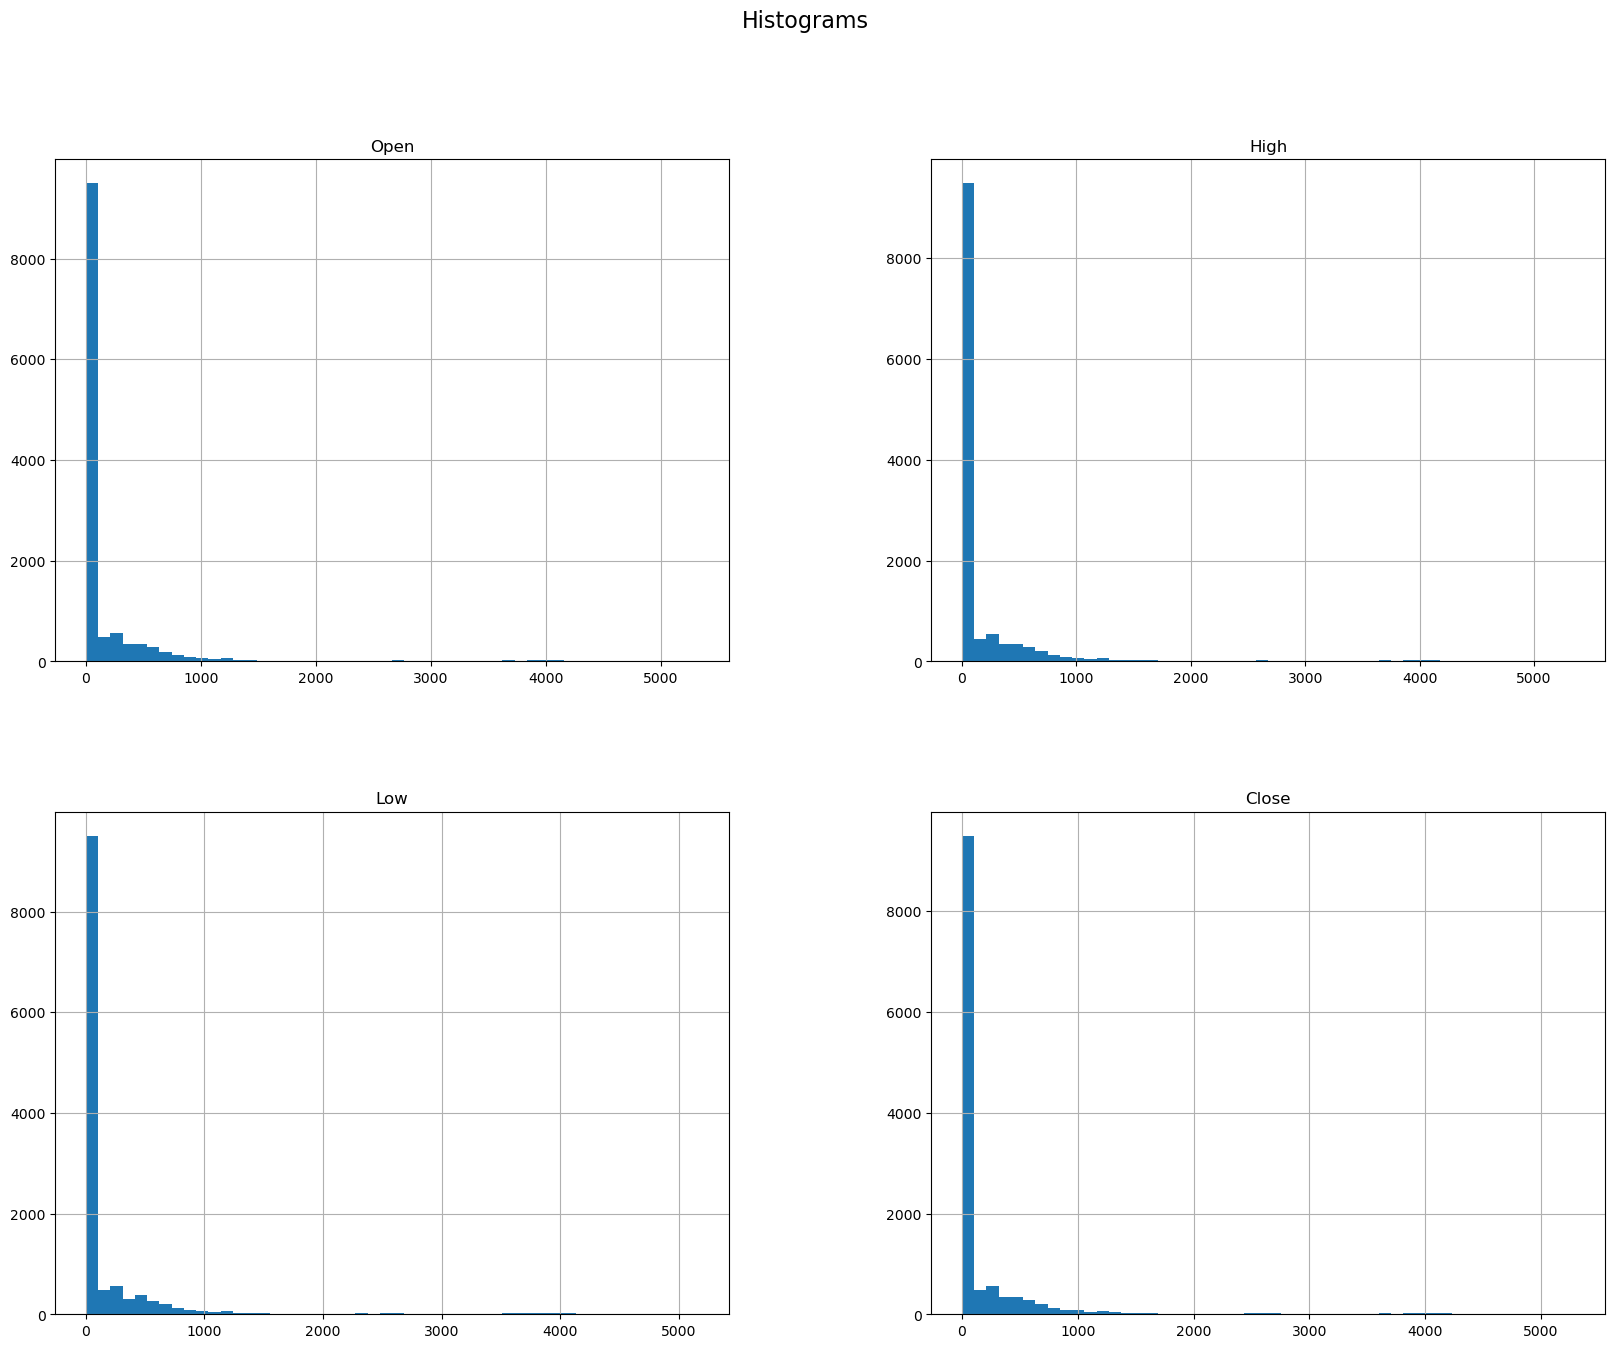

Boxplots for Numerical Columns:


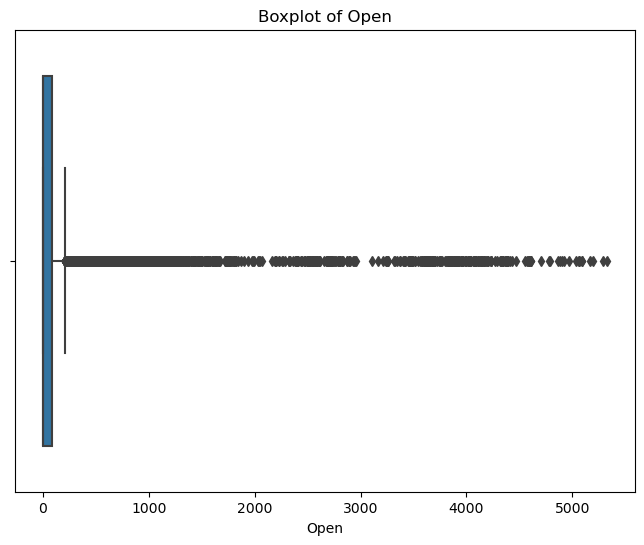

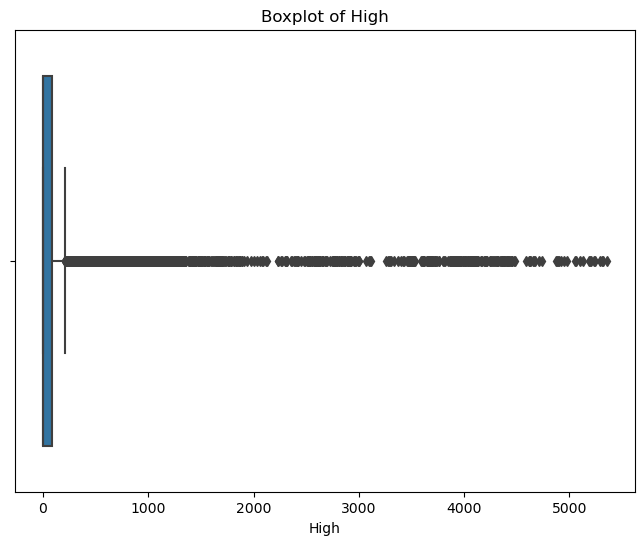

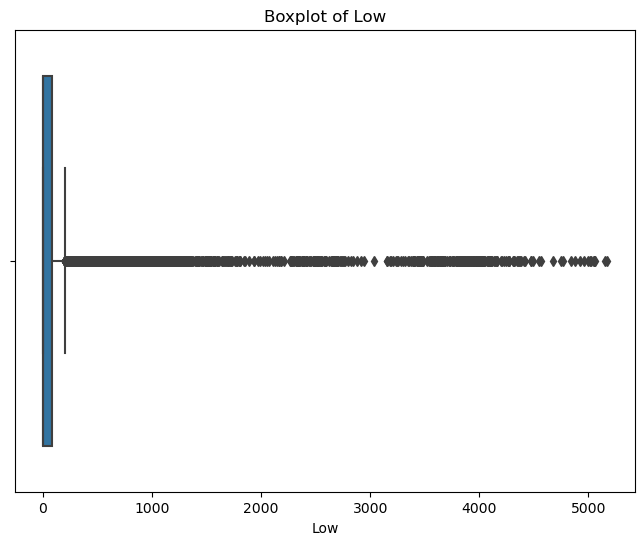

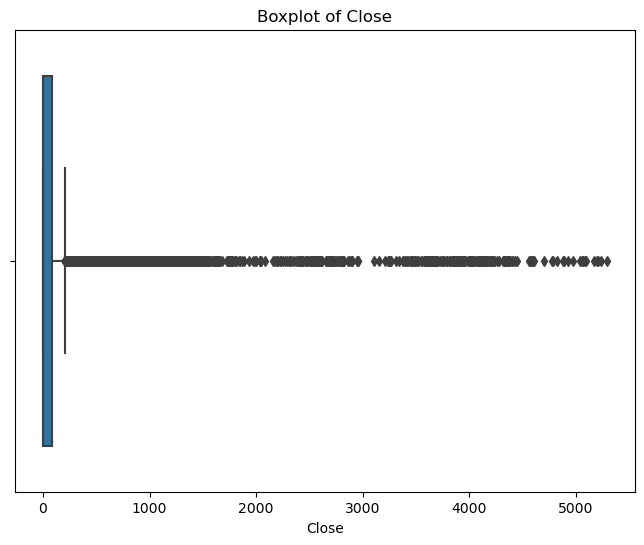

Pair Plot for Numerical Columns:


c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

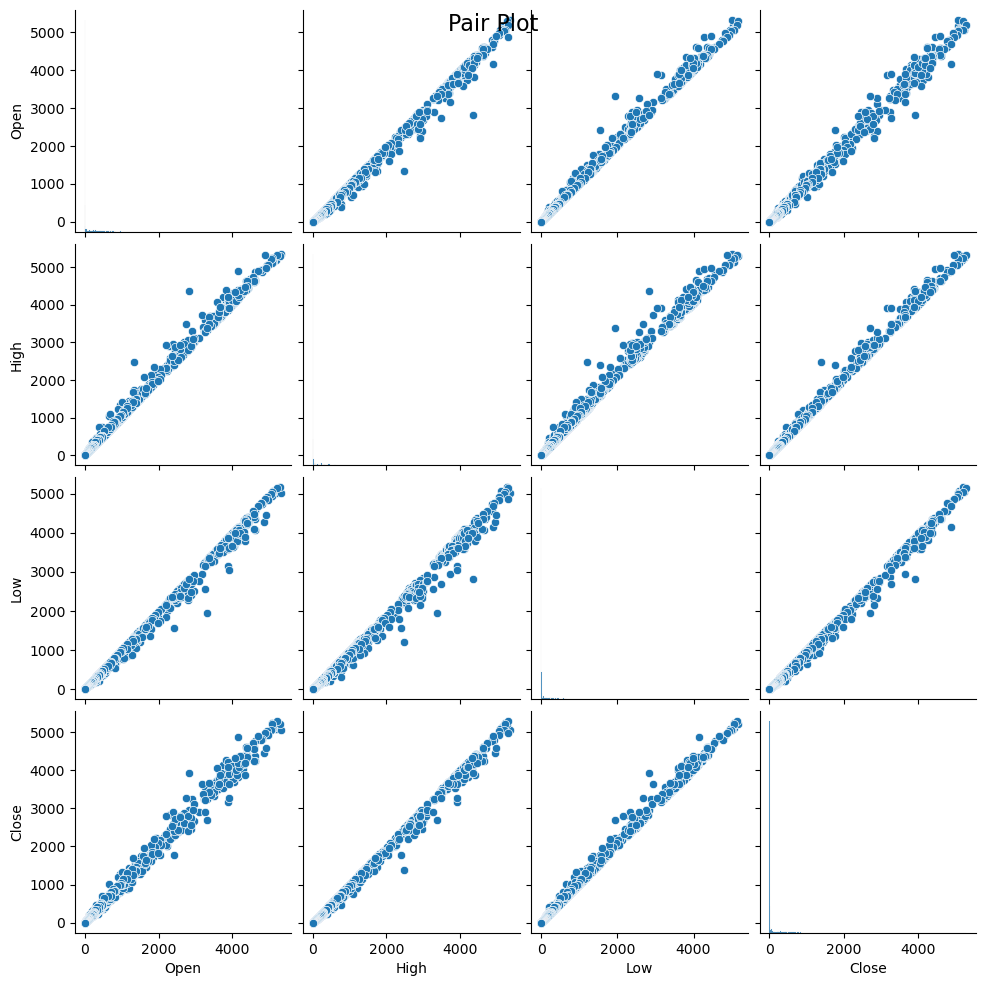

Heatmap Correlation:


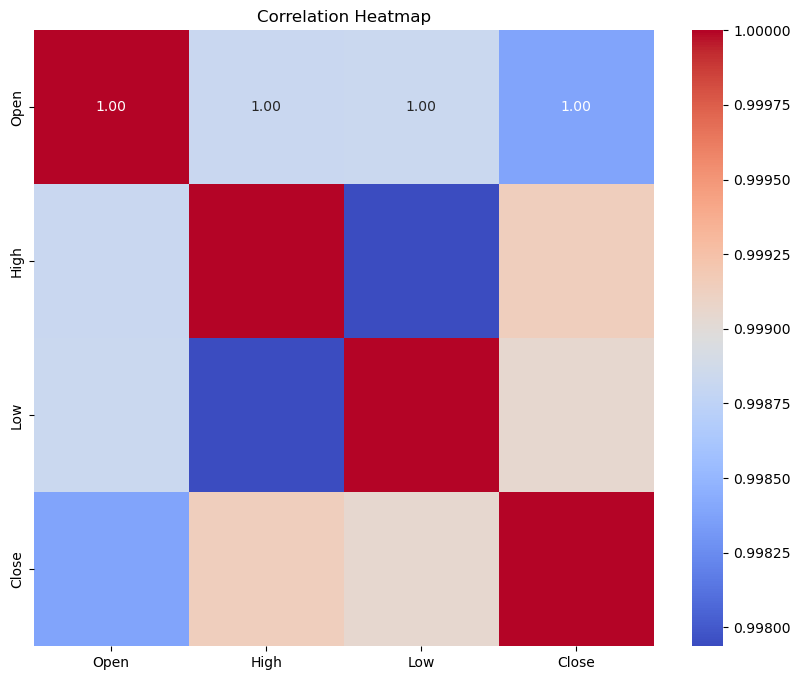

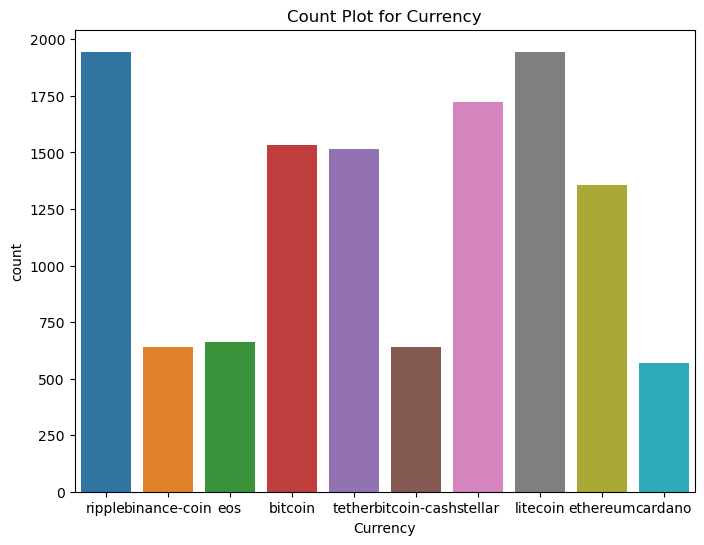

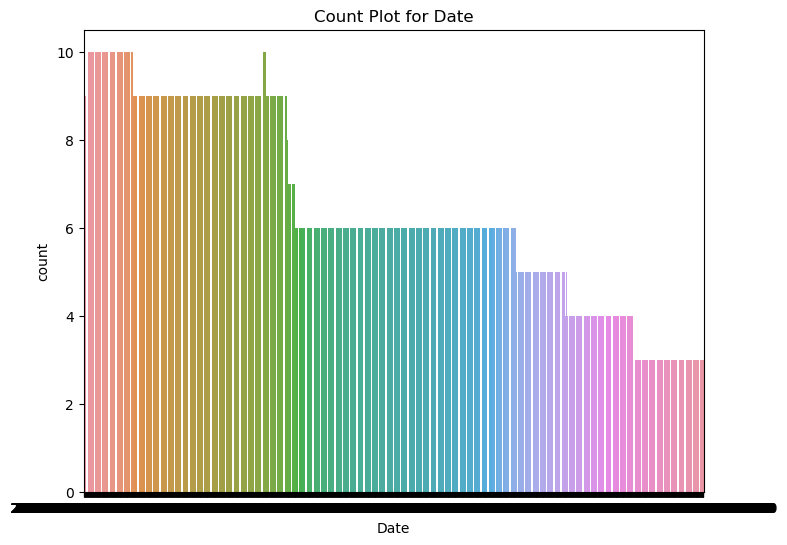

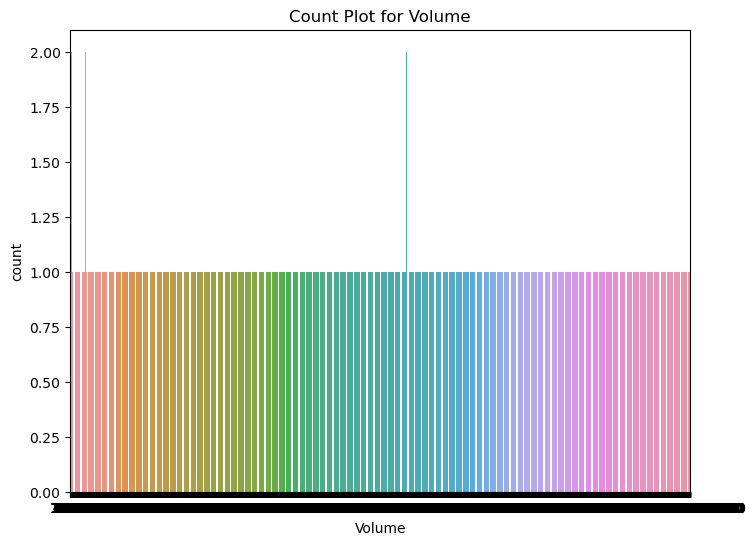

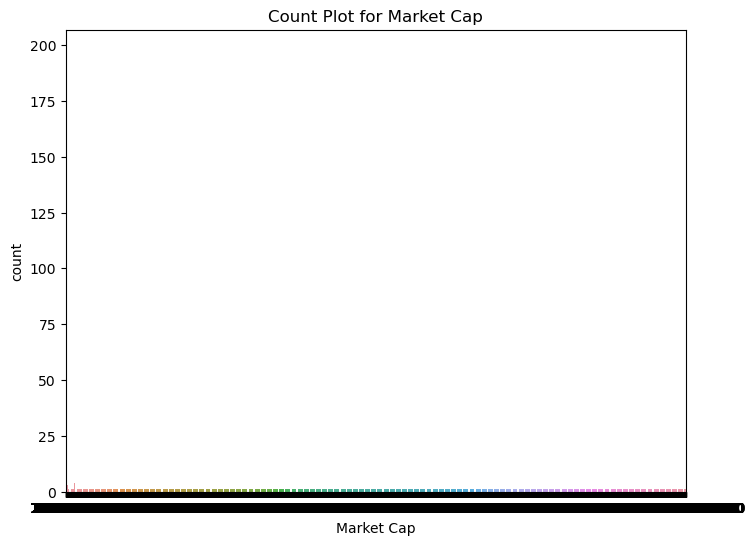

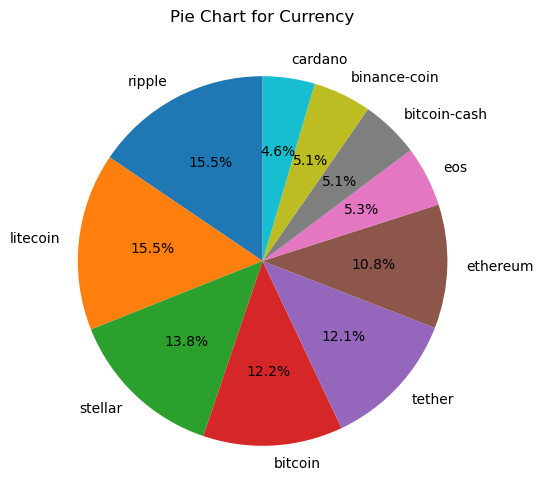

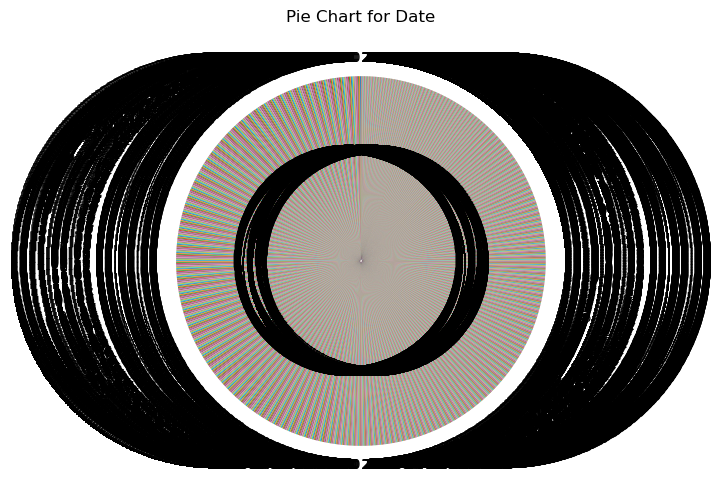

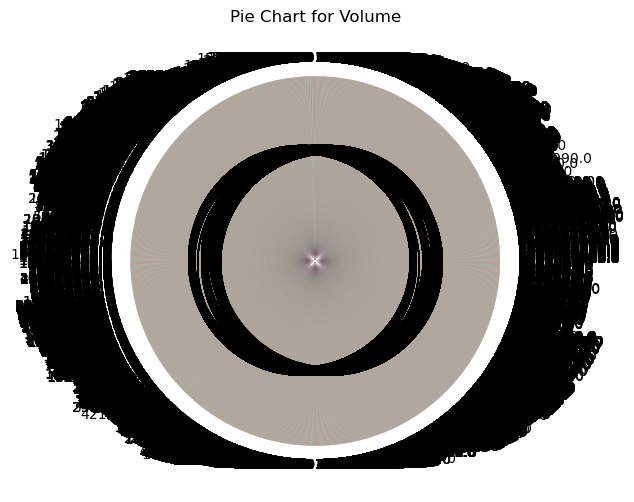

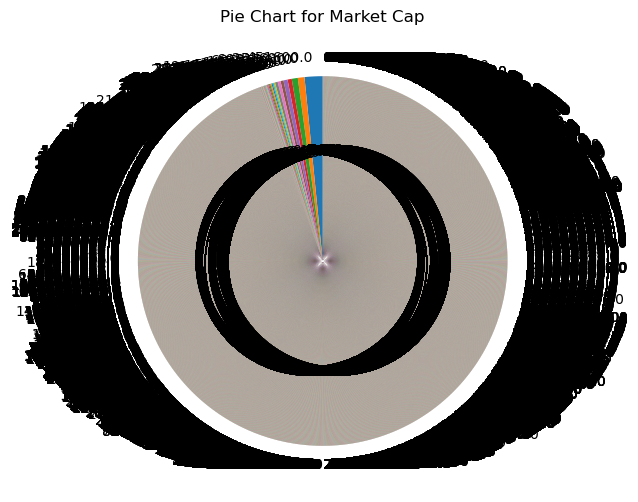

Line Plot for Temporal Data:


C:\Users\ADITHYAN\AppData\Local\Temp\ipykernel_19600\191337482.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column])


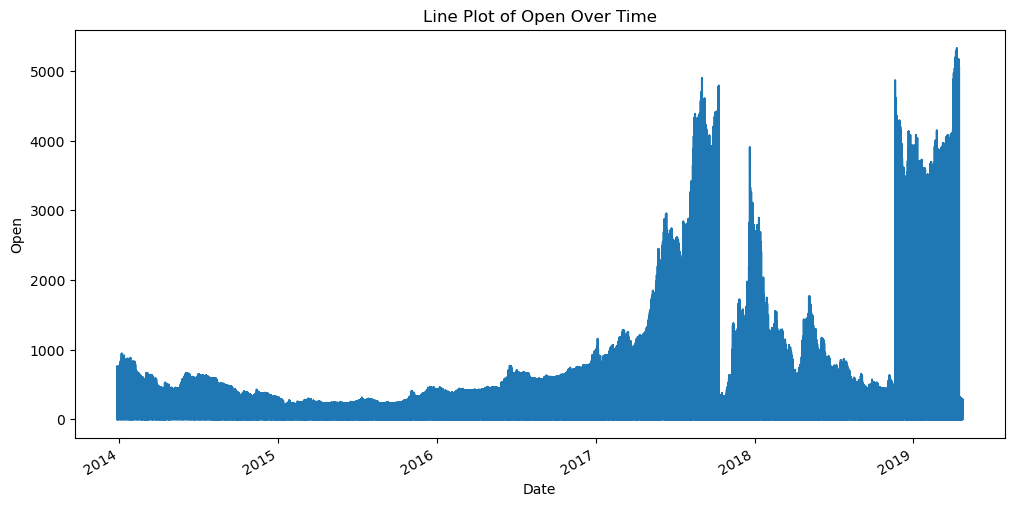

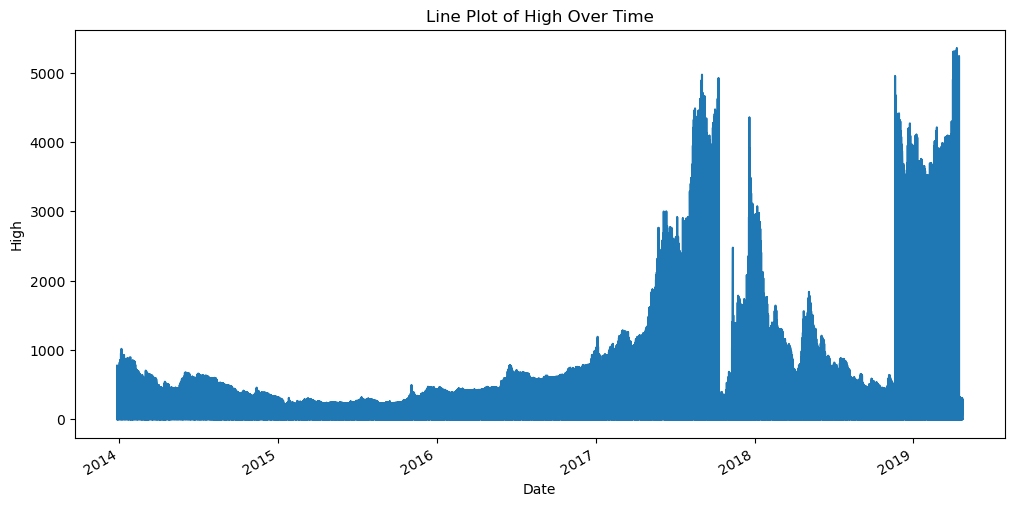

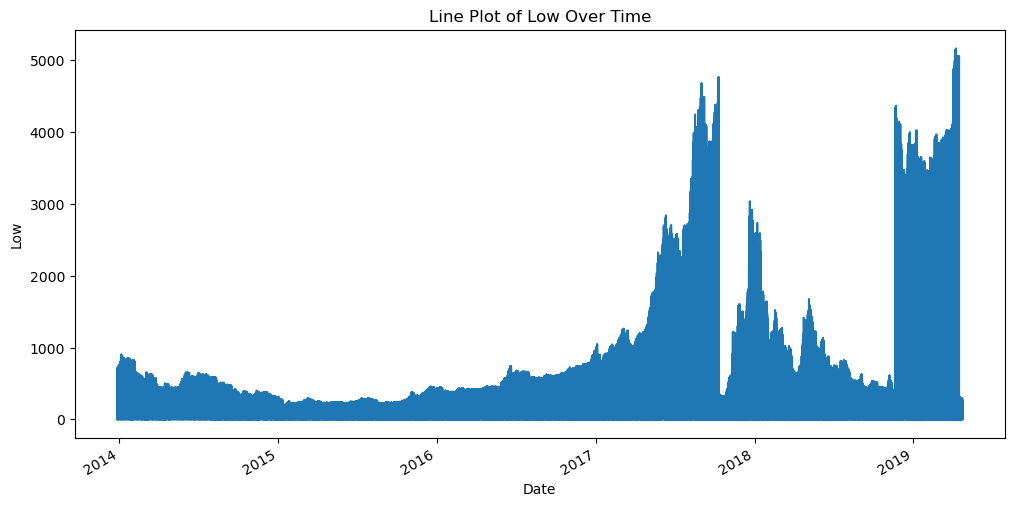

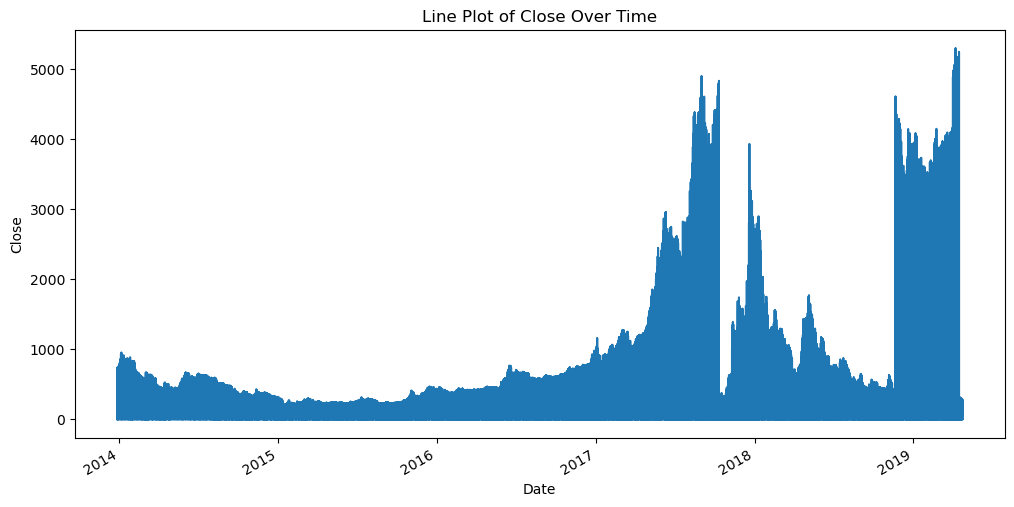

Kernel Density Estimation (KDE) for Numerical Columns:


C:\Users\ADITHYAN\AppData\Local\Temp\ipykernel_19600\191337482.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


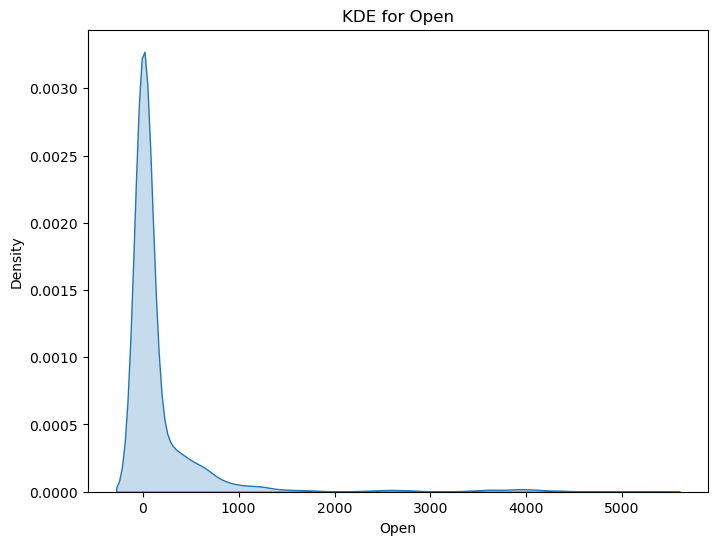

C:\Users\ADITHYAN\AppData\Local\Temp\ipykernel_19600\191337482.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


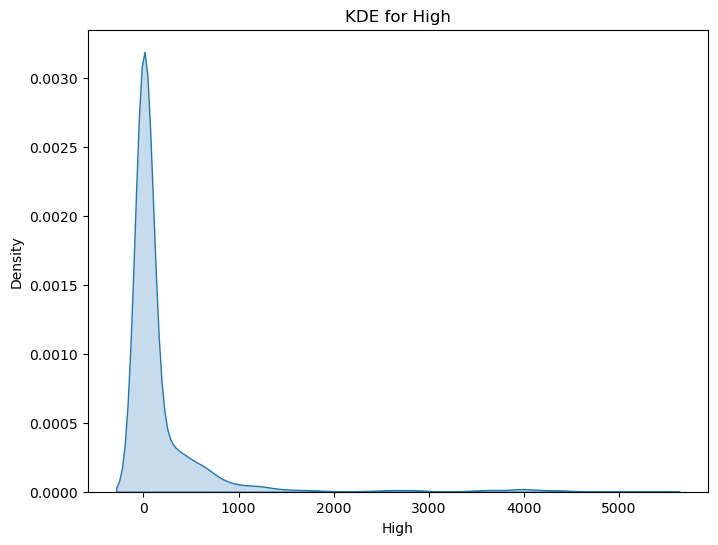

C:\Users\ADITHYAN\AppData\Local\Temp\ipykernel_19600\191337482.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


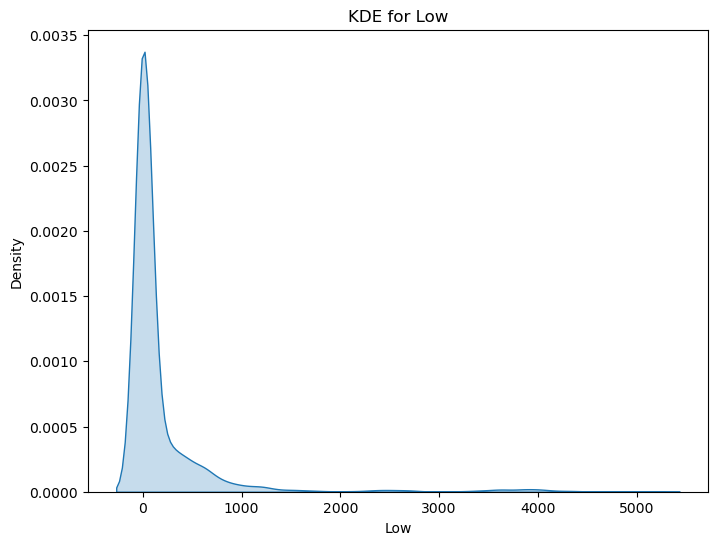

C:\Users\ADITHYAN\AppData\Local\Temp\ipykernel_19600\191337482.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column], shade=True)
c:\Users\ADITHYAN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


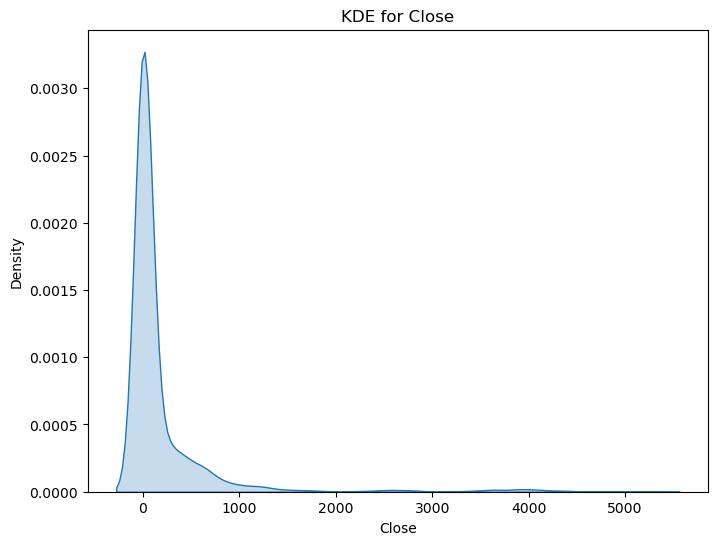

In [9]:
def explore_data(data, numerical_columns, categorical_columns=None, date_column=None):
   # Histogram for numerical columns
    print("Histograms for Numerical Columns:")
    data[numerical_columns].hist(bins=50, figsize=(20, 15))
    plt.suptitle("Histograms", fontsize=16)
    plt.show()

    # Boxplot for numerical columns
    print("Boxplots for Numerical Columns:")
    for column in numerical_columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=data[column])
        plt.title(f"Boxplot of {column}")
        plt.show()

    # Pair Plot for numerical columns
    print("Pair Plot for Numerical Columns:")
    sns.pairplot(data[numerical_columns])
    plt.suptitle("Pair Plot", fontsize=16)
    plt.show()

    # Correlation Heatmap
    print("Heatmap Correlation:")
    plt.figure(figsize=(10, 8))
    sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    # Bar Plot and Count Plot for Categorical Columns
    if categorical_columns:
        for column in categorical_columns:
            plt.figure(figsize=(8, 6))
            sns.countplot(x=data[column])
            plt.title(f"Count Plot for {column}")
            plt.show()

    # Pie Chart for Categorical Columns
    if categorical_columns:
        for column in categorical_columns:
            plt.figure(figsize=(8, 6))
            data[column].value_counts().plot.pie(autopct="%1.1f%%", startangle=90)
            plt.title(f"Pie Chart for {column}")
            plt.ylabel("")
            plt.show()

    # Line Plot for Temporal Data
    if date_column and date_column in data.columns:
        print("Line Plot for Temporal Data:")
        data[date_column] = pd.to_datetime(data[date_column])
        for column in numerical_columns:
            plt.figure(figsize=(12, 6))
            data.set_index(date_column)[column].plot()
            plt.title(f"Line Plot of {column} Over Time")
            plt.ylabel(column)
            plt.show()

    # Kernel Density Estimation (KDE) for Numerical Columns
    print("Kernel Density Estimation (KDE) for Numerical Columns:")
    for column in numerical_columns:
        plt.figure(figsize=(8, 6))
        sns.kdeplot(data[column], shade=True)
        plt.title(f"KDE for {column}")
        plt.show()

# Example usage:
explore_data(df_no_outliers, numerical_columns, categorical_columns, date_column='Date')

Encode categorical features 

In [10]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

# Select numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),  # Scale numeric columns
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # One-hot encode categorical columns
    ]
)

# Apply the transformations
df_processed = preprocessor.fit_transform(df)

print("Processed Data Shape:", df_processed.shape)
df.info()

Processed Data Shape: (12945, 27156)
<class 'pandas.core.frame.DataFrame'>
Index: 12945 entries, 0 to 13575
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Currency    12945 non-null  int32  
 1   Date        12945 non-null  int64  
 2   Open        12945 non-null  float64
 3   High        12945 non-null  float64
 4   Low         12945 non-null  float64
 5   Close       12945 non-null  float64
 6   Volume      12945 non-null  int64  
 7   Market Cap  12945 non-null  int64  
dtypes: float64(4), int32(1), int64(3)
memory usage: 859.6 KB


Feature Selection

In [11]:
# Step 1: Convert sparse matrix to dense if necessary
if hasattr(df_processed, "toarray"):
    df_processed = df_processed.toarray()

# Step 2: Get feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Verify the shapes align
print(f"Shape of df_processed: {df_processed.shape}")
print(f"Number of feature names: {len(feature_names)}")

# Step 3: Convert df_processed to DataFrame with correct feature names
df_processed = pd.DataFrame(df_processed, columns=feature_names)

# Step 4: Ensure 'Market Cap' is preserved as the target variable
y = df['Market Cap']

# Step 5: SelectKBest for top features
k_best = SelectKBest(score_func=f_regression, k=10)
X_k_best = k_best.fit_transform(df_processed, y)

# Get the selected feature indices and names
selected_indices = k_best.get_support(indices=True)
selected_features = np.array(feature_names)[selected_indices]

print("Selected features using SelectKBest:")
print(selected_features)

# Step 6: RandomForestRegressor for feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df_processed, y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking using RandomForestRegressor:")
for f in range(len(feature_names)):
    print(f"{f + 1}. Feature {feature_names[indices[f]]} ({importances[indices[f]]})")

# Step 7: Select top features based on importance
top_features = indices[:5]
X_top_features = df_processed.iloc[:, top_features]

print("Top features selected using RandomForestRegressor:")
print(np.array(feature_names)[top_features])


Shape of df_processed: (12945, 27156)
Number of feature names: 27156
Selected features using SelectKBest:
['num__Date' 'num__Open' 'num__High' 'num__Low' 'num__Close' 'num__Volume'
 'cat__Currency_1' 'cat__Currency_2' 'cat__Currency_8' 'cat__Currency_9']
Feature ranking using RandomForestRegressor:
1. Feature num__Market Cap (0.9999984372388075)
2. Feature num__Close (1.2893035557388067e-06)
3. Feature num__High (8.132768068792027e-08)
4. Feature num__Low (7.972440344038347e-08)
5. Feature num__Volume (2.4346402422387704e-08)
6. Feature num__Date (2.3571012119822214e-08)
7. Feature num__Open (1.7665379916878597e-08)
8. Feature cat__Currency_9 (3.1844604135825783e-09)
9. Feature cat__Currency_8 (2.657376886734039e-09)
10. Feature cat__Currency_6 (1.3055823229094862e-09)
11. Feature cat__Currency_5 (1.1540871938797244e-09)
12. Feature cat__Currency_7 (1.1536567227001299e-09)
13. Feature cat__Currency_1 (9.606817958671302e-10)
14. Feature cat__Currency_4 (6.474189459937695e-10)
15. Featur

 Training and Testing in standardscaler

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the same scaler
X_test_scaled = scaler.transform(X_test)

# Print the shape of the scaled datasets
print("Scaled Training set shape:", X_train_scaled.shape)
print("Scaled Testing set shape:", X_test_scaled.shape)

Scaled Training set shape: (10356, 5)
Scaled Testing set shape: (2589, 5)


ML Model's-Evaluation

In [13]:
def train_regression_models(X_train, y_train, X_test, y_test):
    regressors = {
        "Linear Regression": LinearRegression(),
        "SVR": SVR(),
        "MLP Regressor": MLPRegressor(max_iter=500, hidden_layer_sizes=(50, 50)),
        "Random Forest Regressor": RandomForestRegressor(n_estimators=50, max_depth=10),
        "Gradient Boost": GradientBoostingRegressor(n_estimators=50, max_depth=5),
        "Adaboost": AdaBoostRegressor(n_estimators=50)
    }

    # Convert data to float32 to reduce memory usage
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    for name, reg in regressors.items():
        print(f"Training {name}...")
        try:
            reg.fit(X_train, y_train)  # Train the model
            y_pred = reg.predict(X_test)

            print(f"Regression Results for {name}:\n")
            print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
            print(f"R^2 Score: {r2_score(y_test, y_pred)}")
        except MemoryError:
            print(f"MemoryError: {name} could not complete due to memory limitations.")
        except Exception as e:
            print(f"An error occurred with {name}: {e}")
        print("=" * 60)
train_regression_models(X_train, y_train, X_test, y_test)


Training Linear Regression...
Regression Results for Linear Regression:

Mean Squared Error: 8.243191587098408e-06
R^2 Score: 1.0
Training SVR...
Regression Results for SVR:

Mean Squared Error: 4888913.787420481
R^2 Score: 0.6411881789629452
Training MLP Regressor...
Regression Results for MLP Regressor:

Mean Squared Error: 1.0731213092803955
R^2 Score: 0.9999999403953552
Training Random Forest Regressor...
Regression Results for Random Forest Regressor:

Mean Squared Error: 1.6184546368430048
R^2 Score: 0.9999998812168345
Training Gradient Boost...
Regression Results for Gradient Boost:

Mean Squared Error: 423.02492191044337
R^2 Score: 0.9999689529516832
Training Adaboost...
Regression Results for Adaboost:

Mean Squared Error: 192575.2520848372
R^2 Score: 0.9858663335268818


In [ ]:
def calculate_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")




In [22]:
# Example model training and prediction
reg = RandomForestRegressor(n_estimators=50, max_depth=10)
reg.fit(X_train, y_train)  # Train the model
y_pred = reg.predict(X_test)  # Get predictions on the test set

# Calculate the regression metrics
calculate_regression_metrics(y_test, y_pred)


Mean Absolute Error (MAE): 0.991323583592403
Mean Squared Error (MSE): 1.588567667337406
Root Mean Squared Error (RMSE): 1.2603839364802323
R2 Score: 0.9999998834103274


In [ ]:
# Define the function to calculate regression metrics
def calculate_regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R2 Score: {r2}")

# Example combined model training, prediction, and evaluation
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    # Initialize and train the model
    reg = RandomForestRegressor(n_estimators=50, max_depth=10)
    reg.fit(X_train, y_train)
    
    # Get predictions on the test set
    y_pred = reg.predict(X_test)
    
    # Calculate and print the regression metrics
    calculate_regression_metrics(y_test, y_pred)

# Example of calling the combined function
# Assuming X_train, y_train, X_test, y_test are already defined
train_and_evaluate_model(X_train, y_train, X_test, y_test)


Hyperparameter Tuning

In [23]:
# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best R^2 Score:", best_score)

# Train the RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_best = best_rf.predict(X_test_scaled)

# Calculate and display regression metrics
calculate_regression_metrics(y_test, y_pred_best)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best R^2 Score: 0.9999999073123554
Mean Absolute Error (MAE): 0.6650826334033618
Mean Squared Error (MSE): 0.71177337857386
Root Mean Squared Error (RMSE): 0.8436666276283897
R2 Score: 0.9999999477608497


checking overfitting

In [24]:
# Calculate metrics on the training set
y_train_pred = best_rf.predict(X_train_scaled)
print("Training Set Metrics:")
calculate_regression_metrics(y_train, y_train_pred)

# Calculate metrics on the test set
y_test_pred = best_rf.predict(X_test_scaled)
print("\nTest Set Metrics:")
calculate_regression_metrics(y_test, y_test_pred)

Training Set Metrics:
Mean Absolute Error (MAE): 0.285174357008325
Mean Squared Error (MSE): 0.14042572946922482
Root Mean Squared Error (RMSE): 0.37473421176778726
R2 Score: 0.9999999897239948

Test Set Metrics:
Mean Absolute Error (MAE): 0.6650826334033618
Mean Squared Error (MSE): 0.71177337857386
Root Mean Squared Error (RMSE): 0.8436666276283897
R2 Score: 0.9999999477608497


Predict Market Cap

In [25]:
# Group the data by currency
grouped_data = df.groupby('Currency')

# Dictionary to store predictions for each currency
currency_predictions = {}

# Iterate over each group
for currency, group in grouped_data:
    # Extract features (X) and target (y) for the group
    feature_order = ['Open', 'High', 'Low', 'Close', 'Volume']
    X_group = group[feature_order].values  # Ensure data matches model format
    y_group = group['Market Cap']
    
    # Predict market cap using the best random forest model
    y_pred_group = best_rf.predict(X_group)
    
    # Store the predictions in the dictionary
    currency_predictions[currency] = y_pred_group

# Display the predictions for each currency
for currency, predictions in currency_predictions.items():
    print(f"Currency: {currency}")
    print(f"Predicted Market Cap: {predictions[:5]}")  # Display first 5 predictions for brevity
    print("-" * 50)


Currency: 0
Predicted Market Cap: [12291.04010714 12291.04010714 12291.04010714 12291.04010714
 12291.04010714]
--------------------------------------------------
Currency: 1
Predicted Market Cap: [12291.04010714 12291.04010714 12291.04010714 12291.04010714
 12291.04010714]
--------------------------------------------------
Currency: 2
Predicted Market Cap: [12291.04010714 12291.04010714 12291.04010714 12291.04010714
 12291.04010714]
--------------------------------------------------
Currency: 3
Predicted Market Cap: [6131.67996429 6145.0452123  6130.36942857 6139.79105159 6149.62516468]
--------------------------------------------------
Currency: 4
Predicted Market Cap: [12222.178125   12235.1172381  12230.97528571 12238.97590476
 12239.5072619 ]
--------------------------------------------------
Currency: 5
Predicted Market Cap: [12291.04010714 12291.04010714 12291.04010714 12291.04010714
 12291.04010714]
--------------------------------------------------
Currency: 6
Predicted Market

Save the Model

In [26]:
# Save the trained model to a file
joblib.dump(best_rf, 'best_rf_model.pkl')

print("Model saved successfully.")

Model saved successfully.


## Conclusion

In this project,successfully developed a predictive model to forecast the market capitalization of cryptocurrencies.Performed extensive data preprocessing, including handling missing values, removing outliers, and transforming skewed data. And also conducted exploratory data analysis and visualizations to understand the data better. Various machine learning models were trained and evaluated, and hyperparameter tuning was performed to optimize the performance of the RandomForestRegressor. The final model achieved a satisfactory R^2 score, indicating its effectiveness in predicting market capitalization.

## Future Work
1. **Real-time Predictions**: Developing a real-time prediction system that continuously updates and forecasts market capitalization based on live data feeds could be highly beneficial for traders and investors.

2. **Incorporate Additional Features**: Future work could involve incorporating more features such as social media sentiment, news articles, and macroeconomic indicators to improve the model's accuracy.

3. **Deployment**: Deploying the model as a web application or API to make it accessible for end-users and integrating it with trading platforms for automated decision-making.

4. **Time Series Analysis**: Implementing time series analysis techniques and models like ARIMA, LSTM, or Prophet could provide better insights and predictions for market capitalization trends over time.

5. **Ensemble Methods**: Exploring advanced ensemble methods such as stacking, blending, or voting could enhance the model's performance by combining the strengths of multiple algorithms.

6. **Model Interpretability**: Implementing techniques like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to interpret the model's predictions and understand the impact of each feature on the market capitalization.

